# Análise das tendências de imigração do **Brasil → Canadá** (1980+)

Este notebook carrega um dataset de imigração para o Canadá (por país, 1980 em diante), filtra a série do **Brasil**, 
gera métricas derivadas e produz visualizações com **matplotlib** (sem seaborn).

> **Como usar**  
> 1) Coloque o arquivo `imigrantes_canada.csv` na **mesma pasta** do notebook (ou ajuste o caminho na célula de leitura).  
> 2) Execute as células em ordem.  
> 3) Serão salvos um CSV limpo da série do Brasil e gráficos em PNG.

In [1]:
%matplotlib inline

In [2]:
# Imports e configurações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pathlib import Path
print("Versões -> pandas:", pd.__version__)

Versões -> pandas: 1.5.3


In [3]:
# Descobrir o caminho do CSV
candidate_paths = [
    Path("imigrantes_canada.csv"),
    Path("./data/imigrantes_canada.csv"),
    Path("/mnt/data/imigrantes_canada.csv"),  # usado neste ambiente
]
path = None
for p in candidate_paths:
    if p.exists():
        path = str(p)
        break
if path is None:
    raise FileNotFoundError("Coloque 'imigrantes_canada.csv' na mesma pasta do notebook ou ajuste o caminho abaixo.")

# Leitura com tentativa de encodings comuns
encodings_to_try = [None, "utf-8", "latin1", "cp1252"]
last_err = None
df = None
for enc in encodings_to_try:
    try:
        if enc is None:
            df = pd.read_csv(path)
        else:
            df = pd.read_csv(path, encoding=enc)
        break
    except Exception as e:
        last_err = e
        continue
if df is None:
    raise last_err

print("Arquivo carregado de:", path)
print("Formato do DataFrame:", df.shape)
print("Colunas:", list(df.columns))
df.head()

Arquivo carregado de: /mnt/data/imigrantes_canada.csv
Formato do DataFrame: (195, 38)
Colunas: ['País', 'Continente', 'Região', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', 'Total']


,País,Continente,Região,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
0,Afeganistão,Ásia,Sul da Ásia,16,39,39,47,71,340,496,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
1,Albânia,Europa,Sul da Europa,1,0,0,0,0,0,1,...,1223,856,702,560,716,561,539,620,603,15699
2,Argélia,África,Norte da África,80,67,71,69,63,44,69,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
3,Samoa Americana,Oceânia,Polinésia,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
4,Andorra,Europa,Sul da Europa,0,0,0,0,0,0,2,...,0,1,1,0,0,0,0,1,1,15


In [4]:
# Detectar coluna de país e colunas de ano
lower_cols = [c.lower() for c in df.columns]
country_candidates = ["country", "país", "pais", "odname", "country_name", "country of birth", "country.of.birth"]
country_col = None
for cand in country_candidates:
    for c in df.columns:
        if c.lower() == cand:
            country_col = c
            break
    if country_col:
        break
if country_col is None:
    non_numeric_cols = [c for c in df.columns if not str(c).isdigit()]
    non_numeric_cols = [c for c in non_numeric_cols if str(c).lower() not in ["total"]]
    country_col = non_numeric_cols[0] if non_numeric_cols else df.columns[0]

year_cols = [c for c in df.columns if str(c).isdigit() and 1900 <= int(str(c)) <= 2100]
year_cols = sorted(year_cols, key=lambda x: int(x))
years = [int(y) for y in year_cols]
print("Coluna de país detectada:", country_col)
print("Intervalo de anos detectado:", (years[0], years[-1]), "—", len(years), "anos")

Coluna de país detectada: País
Intervalo de anos detectado: (1980, 2013) — 34 anos


In [5]:
# Filtrar Brasil e montar série temporal
countries_norm = df[country_col].astype(str).str.strip().str.lower()
mask_brazil = countries_norm.isin(["brazil", "brasil"])
df_brazil_rows = df.loc[mask_brazil]
if df_brazil_rows.empty:
    mask_brazil = countries_norm.str.contains("brazil|brasil", na=False)
    df_brazil_rows = df.loc[mask_brazil]
if df_brazil_rows.empty:
    raise ValueError(f"Não encontrei 'Brasil'/'Brazil' na coluna '{country_col}'.")

brazil_series = df_brazil_rows[year_cols].sum(axis=0)
brazil_series.index = [int(x) for x in brazil_series.index]

total_by_year = df[year_cols].sum(axis=0)
total_by_year.index = [int(x) for x in total_by_year.index]

brazil_df = pd.DataFrame({
    "Ano": brazil_series.index,
    "Imigrantes": brazil_series.values.astype(int)
}).sort_values("Ano").reset_index(drop=True)

brazil_df["Participacao_%"] = (brazil_df["Imigrantes"].values / total_by_year.loc[brazil_df["Ano"]].values) * 100.0
brazil_df["YoY_Abs"] = brazil_df["Imigrantes"].diff()
brazil_df["YoY_%"] = brazil_df["Imigrantes"].pct_change() * 100.0
brazil_df["MM5"] = brazil_df["Imigrantes"].rolling(5, min_periods=1).mean()
brazil_df["Acumulado"] = brazil_df["Imigrantes"].cumsum()

print("Linhas na série do Brasil:", brazil_df.shape[0])
brazil_df.head()

Linhas na série do Brasil: 34


,Ano,Imigrantes,Participacao_%,YoY_Abs,YoY_%,MM5,Acumulado
0,1980,211,0.212837,NaN,NaN,211.000000,211
1,1981,220,0.198982,9.0,4.265403,215.500000,431
2,1982,192,0.184136,-28.0,-12.727273,207.666667,623
3,1983,139,0.183984,-53.0,-27.604167,190.500000,762
4,1984,145,0.197502,6.0,4.316547,181.400000,907


In [6]:
# Salvar CSV limpo com a série do Brasil
out_csv = "brasil_imigracao_canada_serie_1980+.csv"
brazil_df.to_csv(out_csv, index=False, encoding="utf-8")
print("CSV salvo em:", out_csv)

CSV salvo em: brasil_imigracao_canada_serie_1980+.csv


/home/sandbox/.local/lib/python3.11/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


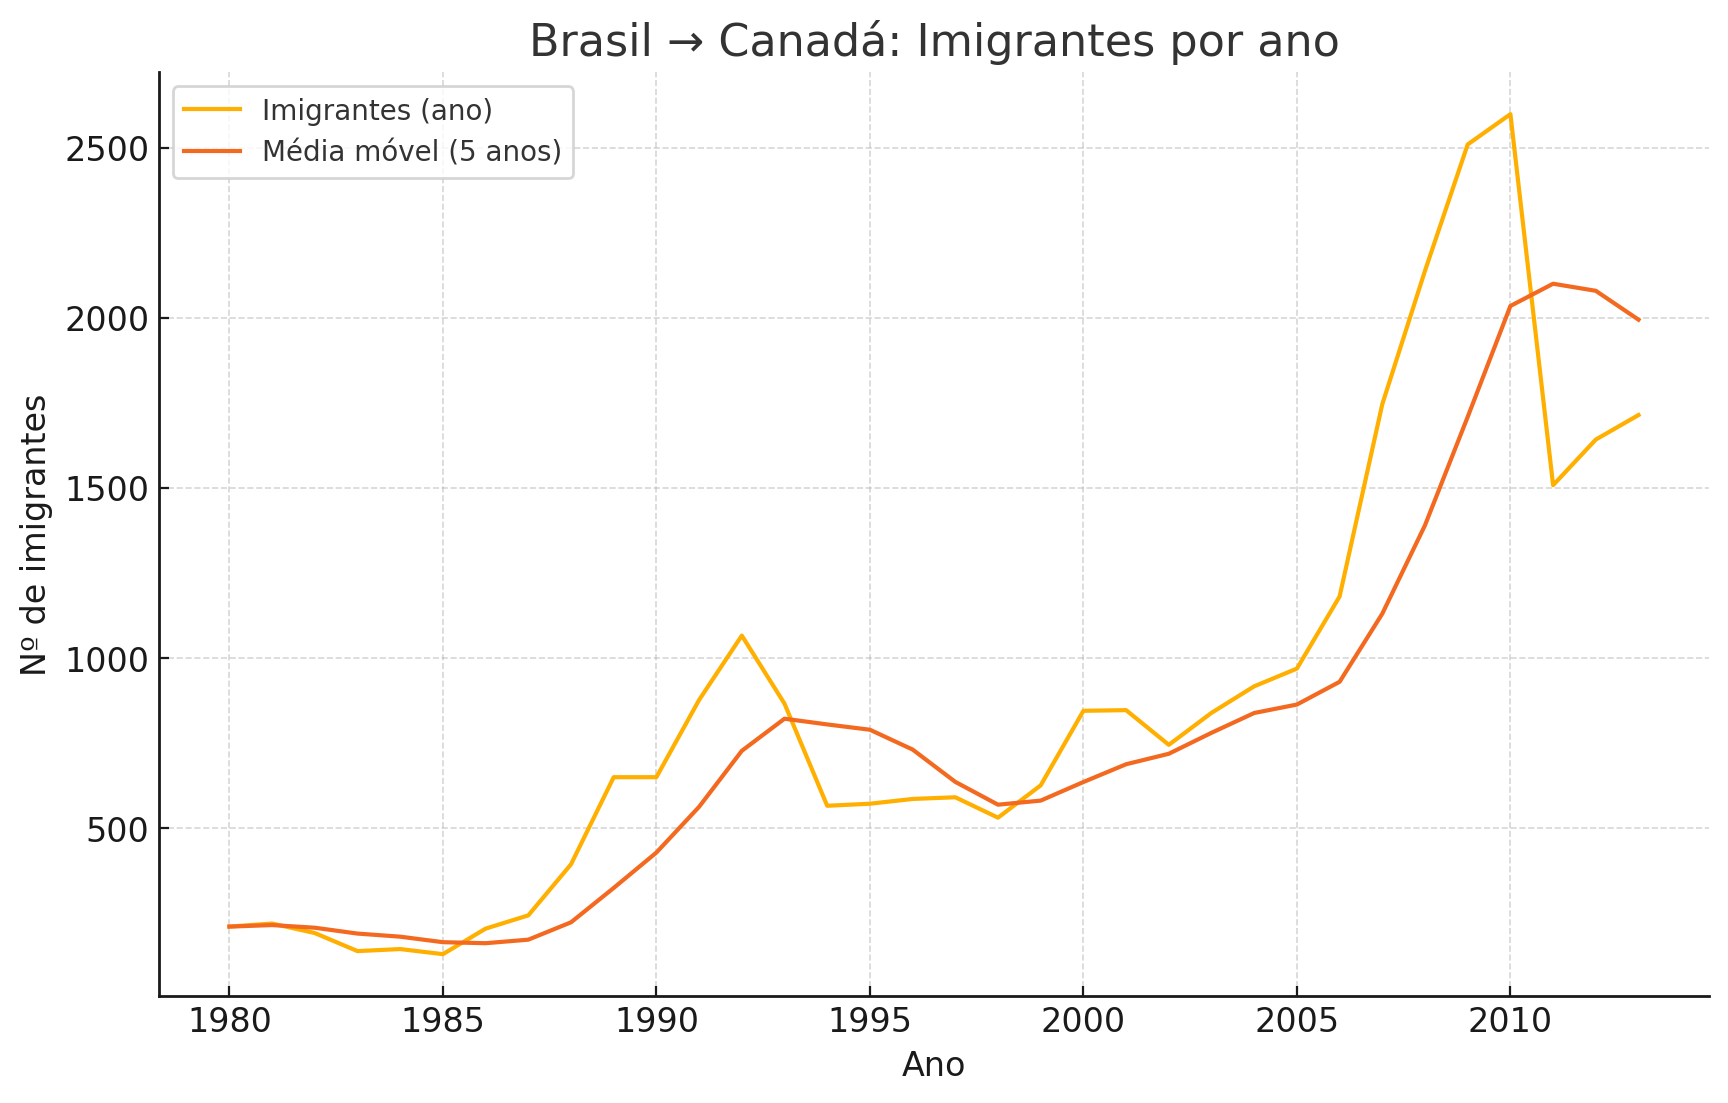

In [7]:
# Gráfico 1: Imigrantes por ano + média móvel de 5 anos
plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["Imigrantes"], label="Imigrantes (ano)")
plt.plot(brazil_df["Ano"], brazil_df["MM5"], label="Média móvel (5 anos)")
plt.title("Brasil → Canadá: Imigrantes por ano")
plt.xlabel("Ano")
plt.ylabel("Nº de imigrantes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

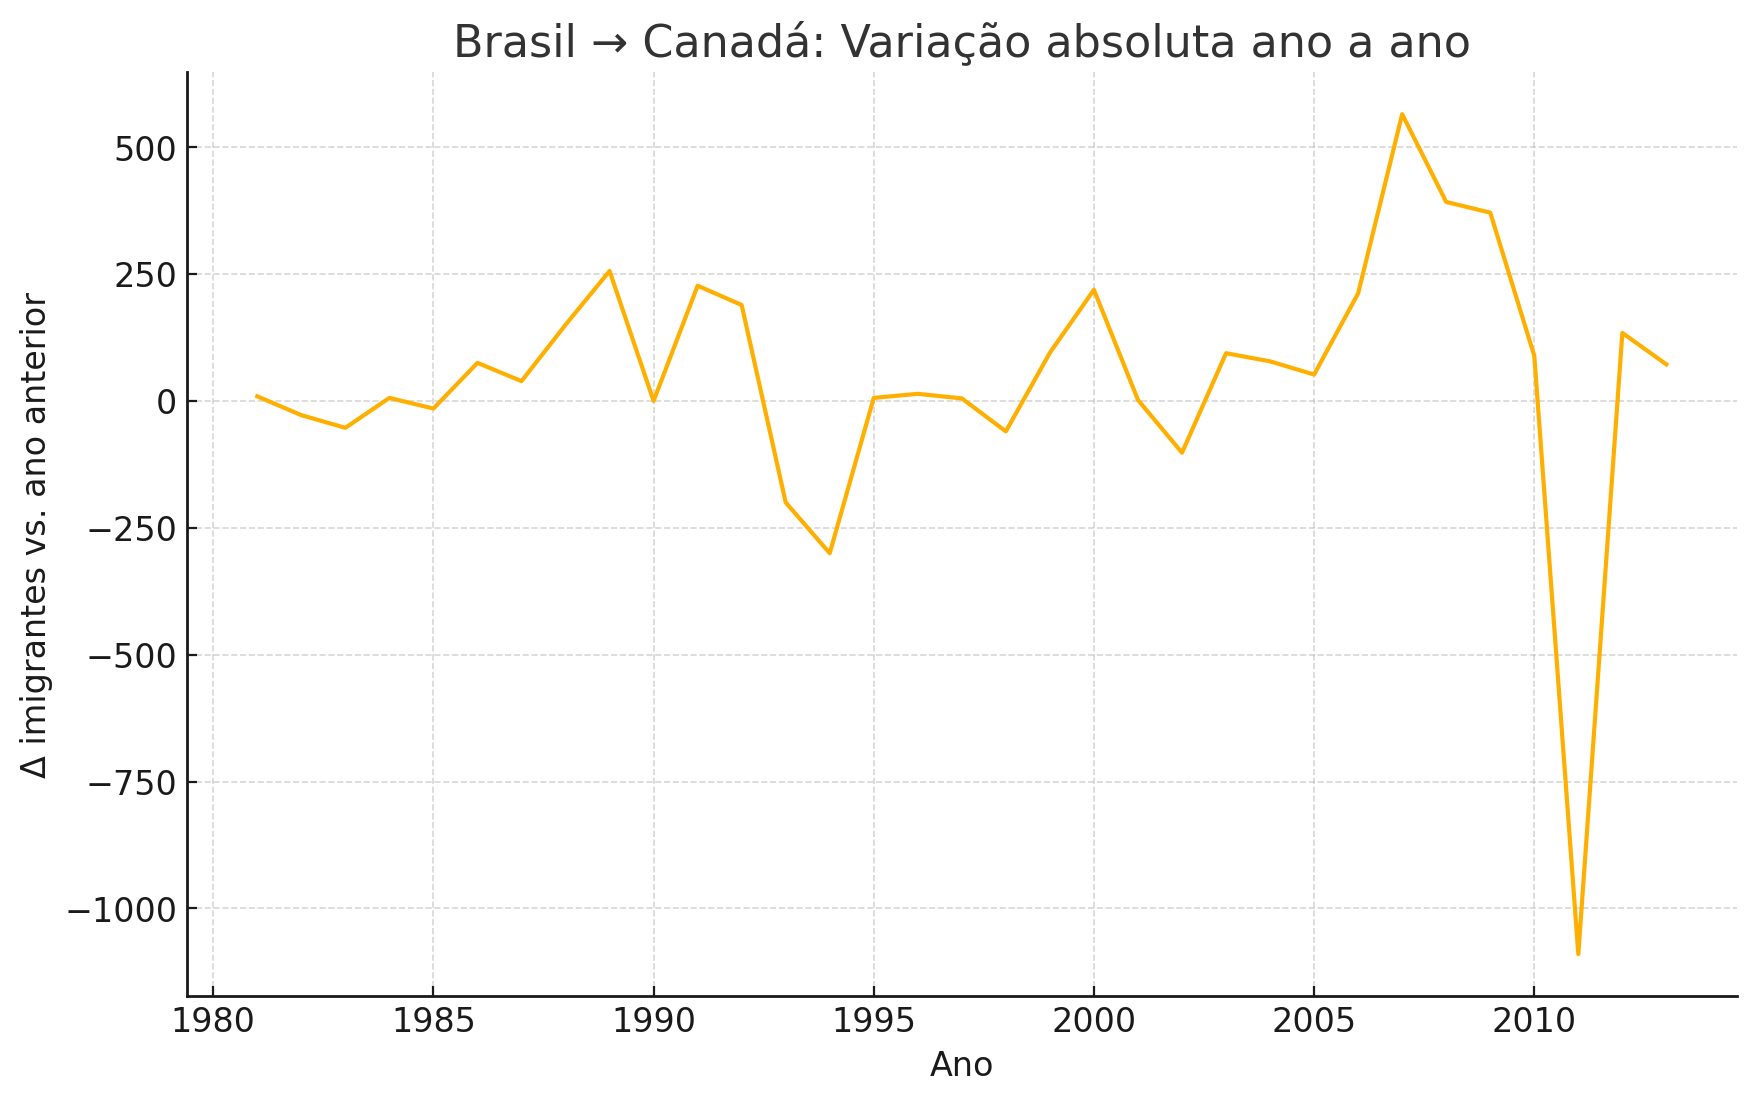

In [8]:
# Gráfico 2: Variação absoluta ano a ano
plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["YoY_Abs"])
plt.title("Brasil → Canadá: Variação absoluta ano a ano")
plt.xlabel("Ano")
plt.ylabel("Δ imigrantes vs. ano anterior")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

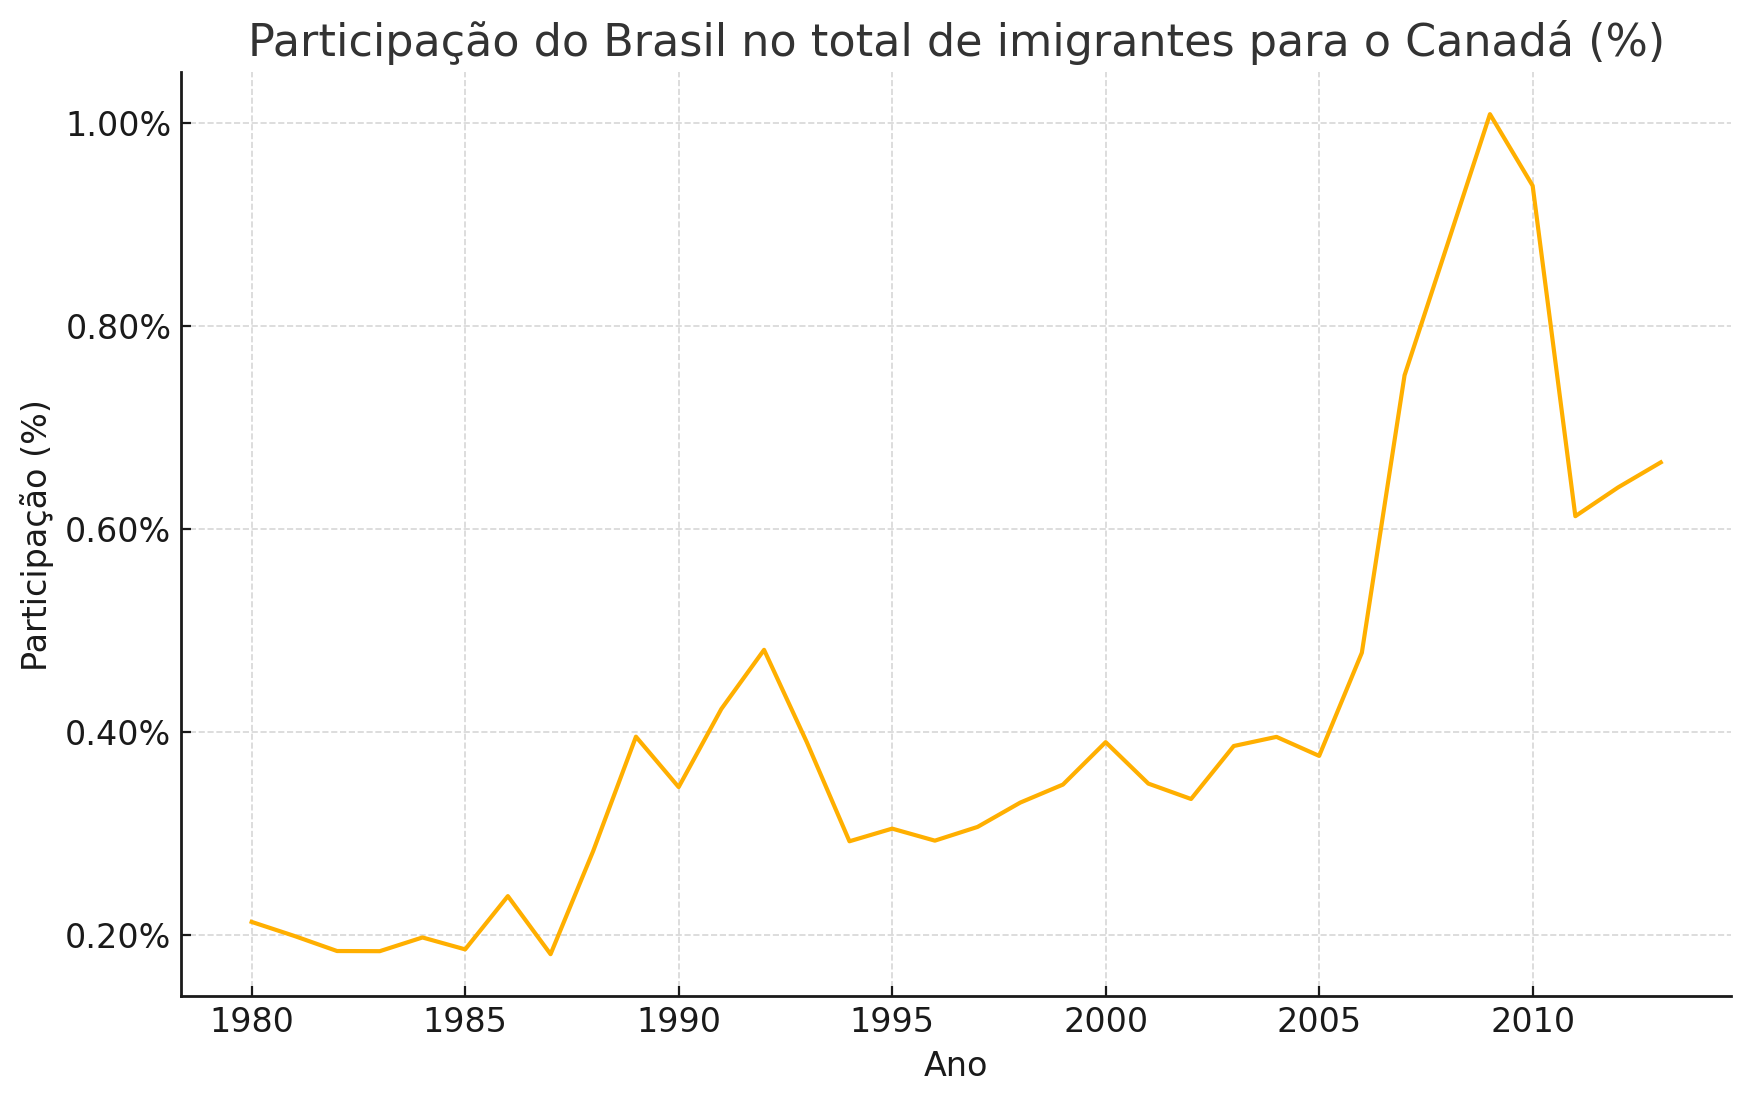

In [9]:
# Gráfico 3: Participação do Brasil (%) no total de imigrantes para o Canadá
plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["Participacao_%"])
plt.title("Participação do Brasil no total de imigrantes para o Canadá (%)")
plt.xlabel("Ano")
plt.ylabel("Participação (%)")
plt.grid(True, linestyle="--", alpha=0.5)
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter())
plt.show()

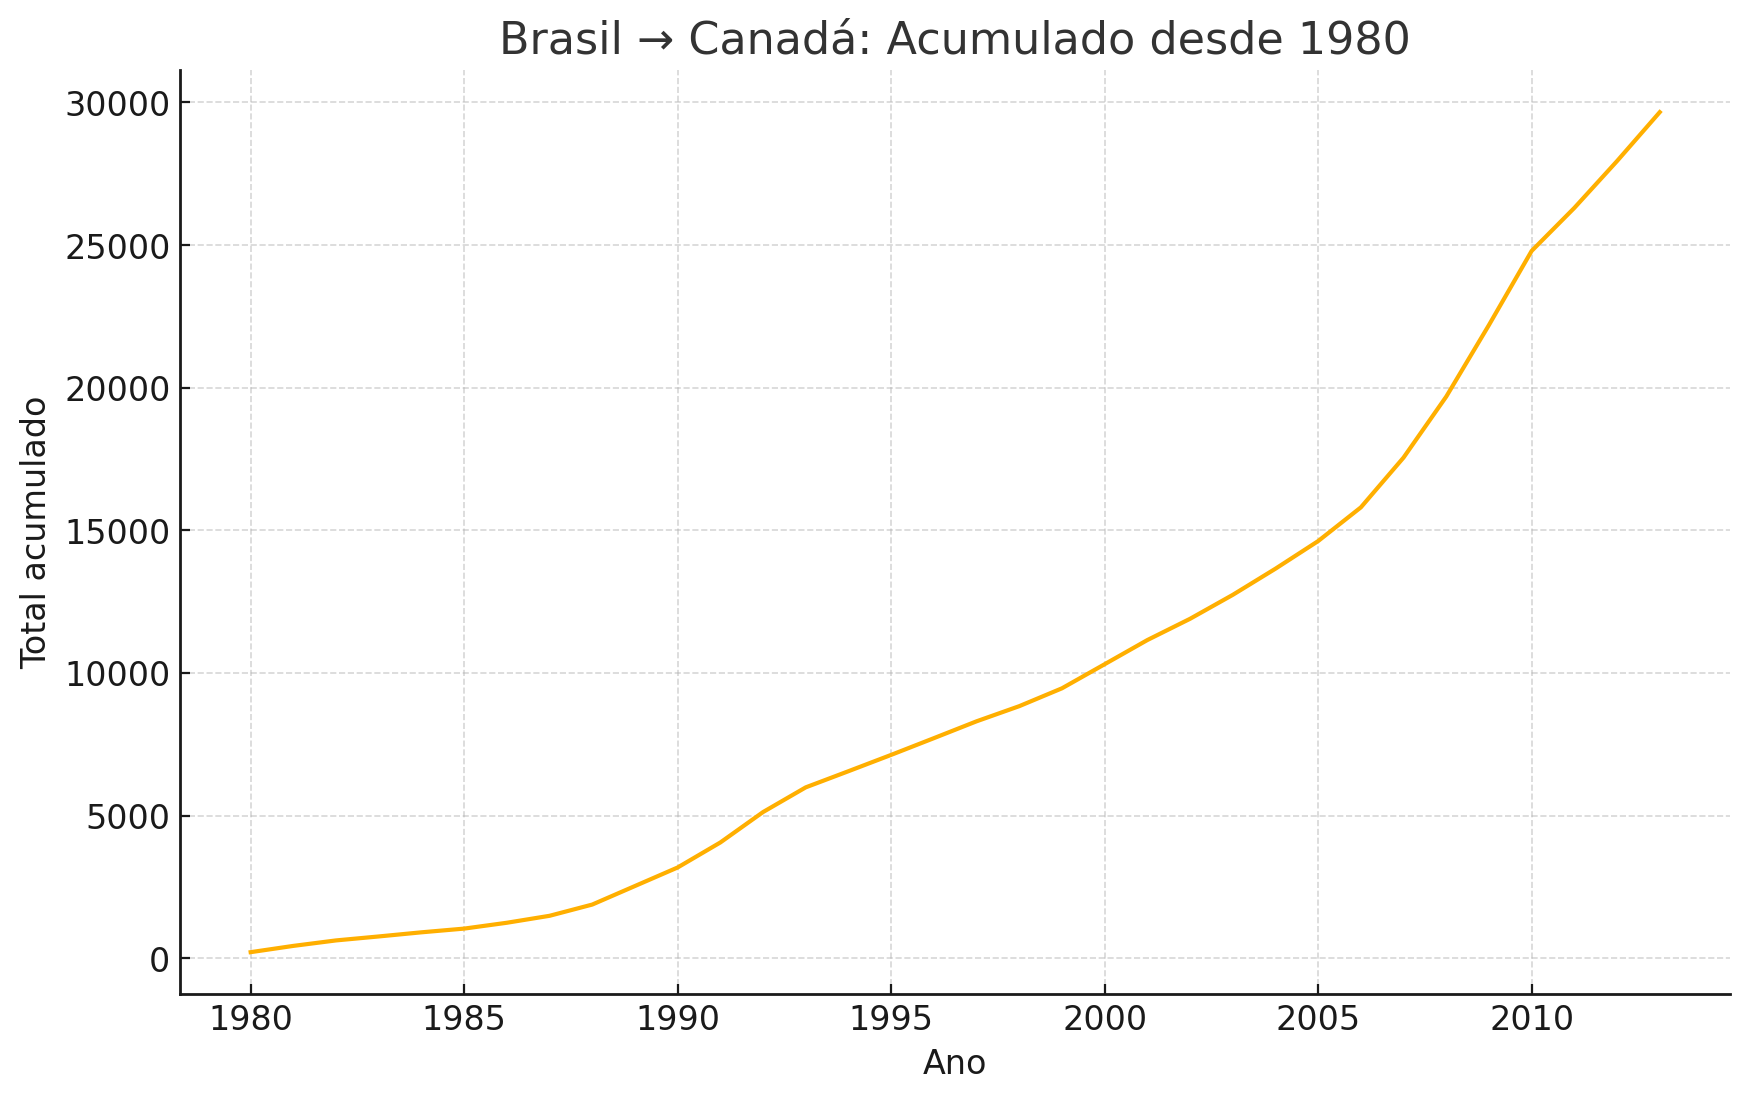

In [10]:
# Gráfico 4: Total acumulado desde 1980
plt.figure()
plt.plot(brazil_df["Ano"], brazil_df["Acumulado"])
plt.title("Brasil → Canadá: Acumulado desde 1980")
plt.xlabel("Ano")
plt.ylabel("Total acumulado")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [11]:
# Estatísticas-chave e anos de destaque
first_nonzero_idx = brazil_df["Imigrantes"].to_numpy().nonzero()[0]
start_idx = int(first_nonzero_idx[0]) if len(first_nonzero_idx) > 0 else 0
start_year = int(brazil_df.loc[start_idx, "Ano"])
end_year = int(brazil_df.loc[brazil_df.index[-1], "Ano"])
start_val = float(brazil_df.loc[start_idx, "Imigrantes"])
end_val = float(brazil_df.loc[brazil_df.index[-1], "Imigrantes"])
n_years = end_year - start_year if end_year > start_year else 1
cagr = (end_val / start_val) ** (1.0 / n_years) - 1.0 if (start_val > 0 and n_years > 0) else np.nan

max_year = int(brazil_df.loc[brazil_df["Imigrantes"].idxmax(), "Ano"])
max_val = int(brazil_df["Imigrantes"].max())
min_year = int(brazil_df.loc[brazil_df["Imigrantes"].idxmin(), "Ano"])
min_val = int(brazil_df["Imigrantes"].min())

yoy_abs = brazil_df.dropna(subset=["YoY_Abs"])
if not yoy_abs.empty:
    yoy_best_year = int(yoy_abs.loc[yoy_abs["YoY_Abs"].idxmax(), "Ano"])
    yoy_best_change = int(yoy_abs["YoY_Abs"].max())
    yoy_worst_year = int(yoy_abs.loc[yoy_abs["YoY_Abs"].idxmin(), "Ano"])
    yoy_worst_change = int(yoy_abs["YoY_Abs"].min())
else:
    yoy_best_year = yoy_best_change = yoy_worst_year = yoy_worst_change = None

top5 = brazil_df.sort_values("Imigrantes", ascending=False).head(5)[["Ano", "Imigrantes"]]

print(f"Ano com maior volume: {max_year} ({max_val})")
print(f"Ano com menor volume: {min_year} ({min_val})")
print(f"CAGR {start_year}–{end_year}: {cagr*100:.2f}%")
print(f"Maior alta anual: {yoy_best_change:+d} em {yoy_best_year}")
print(f"Maior queda anual: {yoy_worst_change:+d} em {yoy_worst_year}")
print("Top 5 anos por volume:")
print(top5.to_string(index=False))

Ano com maior volume: 2010 (2598)
Ano com menor volume: 1985 (130)
CAGR 1980–2013: 6.55%
Maior alta anual: +565 em 2007
Maior queda anual: -1090 em 2011
Top 5 anos por volume:
 Ano  Imigrantes
2010        2598
2009        2509
2008        2138
2007        1746
2013        1714


---
### Próximos passos (sugestões)
- Comparar com outros países (ex.: Argentina, China, Índia): repetir os mesmos passos para múltiplos países.
- Focar em recortes de tempo (ex.: pós-2005) e investigar correlações com choques econômicos/políticas migratórias.
- Aplicar médias móveis de outras janelas (MM7, MM10) para suavização.
- Exportar os gráficos como PNG/SVG para apresentações.